<a href="https://colab.research.google.com/github/jagorn/NMA2020_group_project/blob/master/ExtractSnippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Setup



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
import os.path
from os import path
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [193]:
# Load data
drivepath = 'drive/My Drive/NMA project/Cori_2016-12-14/'
spiketimes = np.load(drivepath + 'spikes.times.npy')
clusters = np.load(drivepath + 'spikes.clusters.npy')
trial_intervals = np.load(drivepath + 'trials.intervals.npy')
included_trials = np.load(drivepath + 'trials.included.npy')
visualStim_times = np.load(drivepath + 'trials.visualStim_times.npy')
goCueTimes = np.load(drivepath +'trials.goCue_times.npy')

Load data for Michalis' function


In [256]:
f_areas = 'channels.brainLocation.tsv'
with open(drivepath + f_areas) as file: # open file as a single string
    lines = file.read().splitlines() # split new lines (string -> list of strings)

# Quality of recordings for a given active neuron
f_quality = 'clusters._phy_annotation.npy'
# Which neuron was detected by which channel:
f_channels = 'clusters.peakChannel.npy'

# LOAD FILES AND CLEAN UNECESSARY INFORMATION .........................
# A list where index -> channel,  value -> brain area
areas_from_channels = [line.split('\t')[-1] for line in lines[1:]]
# 1D numpy array where index -> neuron, value -> channel where it is recorded from
channels = np.load(drivepath +f_channels)
# 1D numpy array where index -> neuron and value -> recording quality score (good >= 2)
quality = np.load(drivepath + f_quality) # index -> cluster (neuron)


# Mapping units and brain areas

In [257]:
def sort_and_clean():
    """
    Returns a dict where keys -> brain areas and values -> list of neurons.
    Neurons with bad quality scores (less than 2) are exluded.
    """
    # Create a list where index -> neuron and value -> area:
    matched = [areas_from_channels[int(c)] for c in channels]
    # Find the indices (aka neurons) where they have a score < 2:
    bad_indices = [i for i, score in enumerate(quality) if score[0] < 2]
    # Create a dictionary to sort neurons according to areas:
    d = {}
    for index, area in enumerate(matched): # Iterate index and value together
        # Discard bad recordings:
        if index not in bad_indices:
            # If the area is already a key then append this neuron index
            if area in d.keys():
                d[area].append(index)
            # Else create a new key for a single element list
            else:
                d[area] = [index]
    return d

# Extract spiketimes from units in one brain area

In [293]:
def area_spiketimes (all_spiketimes, brain_area):
  # Create a dicionary where keys -> brain areas and values -> list of neurons
  sorted_areas = sort_and_clean()
  # Choose area of interest
  area = sorted_areas[brain_area]
  # Create an mask to keep only rows of interest
  area_filter = np.isin(all_spiketimes[:,0], area)
  # Fetch only desired spiketimes
  area_spiketimes = all_spiketimes[area_filter]
  return area, area_spiketimes

In [297]:
# # Merge spiketimes into a single 2d array
all_spiketimes = np.hstack((clusters, spiketimes))
ca3, ca3_spiketimes = area_spiketimes (all_spiketimes, 'CA3')
print('Neurons in CA3: ', ca3)
print('First spikes belong to neuron ', ca3_spiketimes[0,0])

Neurons in CA3:  [554, 555, 572, 573, 576, 589, 590, 595, 605, 627, 638, 657, 661, 682, 683, 694, 696, 713, 717, 723, 747, 760, 768, 774, 824, 825, 827, 838, 841, 854, 861, 902, 906, 910, 911, 923, 939, 942, 955, 956, 960, 981, 987, 992, 1008, 1029, 1030, 1031, 1033, 1035, 1041, 1043, 1046, 1052, 1055, 1059, 1061, 1064, 1065, 1066, 1069, 1070, 1073, 1074, 1075, 1078]
First spikes belong to neuron  838.0


# Remove discarded trials


In [69]:
def clean_trials (trial_intervals, included_trials):
#   Remove trials that were not included
#   INPUT: trial_intervals  - onset and offset timestamps of a N trials
#          included_trials - boolean +1 included, 0 not included
#
  idx = np.where(included_trials == 1 )
  idx = idx[0]
  return trial_intervals[idx,:]



In [114]:
clean_trial_intervals = clean_trials(trial_intervals, included_trials)
print ('Shape before cleaning:',trial_intervals.shape)
print ('Shape after cleaning:',clean_trial_intervals.shape)



Shape before cleaning: (214, 2)
Shape after cleaning: (201, 2)


# Extract spike snippets during trials

In [309]:
def extract_snippets_spikes (trial_intervals, all_spiketimes):
#   Extract spiketimes and unit id (clusters) occured within the trial window.
#   INPUT : trial_intervals  - onset and offset timestamps of a N trials, use cleaned version
#           all_spiketimes (Nx2) - a vector containing neuron ids and spike times
#           clusters - unit/neuron id for a given spike, same shape as spiketimes
#           good_data - 
#           brain_area ex. 'CA1'
#       
#  OUTPUT: snippets  - spiketimes and unit id from a certain brain area during trials. List size of N trials each containing n x 2 array (spiketimes, unit id)

  TrialNum = trial_intervals.shape[0]
  #UnitIds = good_data[brain_area] # Unit ids from the specified brain area

  # Initialize
  snippets = []

  # Loop over trials
  for trial in range(0,TrialNum):
    spikes = [];
    # Onset and offset of a trial
    onset = trial_intervals[trial,0]
    offset = trial_intervals[trial,1]
    
    # Spikes between trial onset and offset
    idx = np.where((all_spiketimes[:,1] >= onset) & (all_spiketimes[:,1] < offset))
    idx = idx[0] # only the indices

  

    spikes= all_spiketimes[idx,:]
    
    
    snippets.append(spikes);
    

  return snippets

In [310]:
# All the neurons
allcells_snippets = extract_snippets_spikes (clean_trial_intervals, all_spiketimes)
print('Spikes in trial 1: ', allcells_snippets[0])




[[1025.           62.90032155]
 [ 111.           62.90083333]
 [ 866.           62.90125488]
 ...
 [1062.           67.42257511]
 [ 109.           67.42276667]
 [ 730.           67.42277511]]


In [319]:
#CA1 neurons
ca3_snippets = extract_snippets_spikes (clean_trial_intervals, ca3_spiketimes)
print(ca1_snippets[0])

[[1033.           62.90158822]
 [1035.           62.90208822]
 [1031.           62.92822167]
 ...
 [ 838.           67.40720837]
 [1075.           67.41710842]
 [ 838.           67.41884176]]


In [314]:
def plot_raster_and_histogram(snippets,trialnum):
  # Raster plot from a trial
  
  #fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, tight_layout=True)

  ax1 = plt.subplot(211)
  ax1.plot(snippets[trialnum][:,1], snippets[trialnum][:,0], 'o')
  ax1.set(xlabel = 'time', ylabel= 'neuron id', ylim=[0, 1200], title = 'Raster plot')  

  ax2 = plt.subplot(212)
  interval = clean_trial_intervals[trialnum,1] -clean_trial_intervals[trialnum,0]
  binsize = 0.100 # 100 ms
  n_bins = int(np.floor(interval/binsize)) # ms

  ax2.hist(snippets[trialnum][:,1], bins=n_bins)
  ax2.set(xlabel='time', ylabel='spikes/s',ylim=[0, 1000], title = 'Population Histogram')

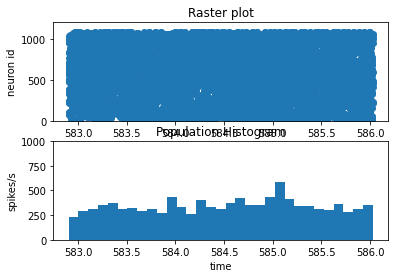

In [315]:
# From all neurons
trialnum = 100
plot_raster_and_histogram(allcells_snippets, trialnum=trialnum)

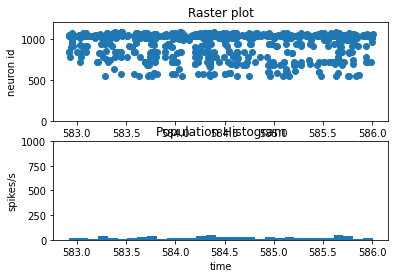

In [320]:
# From CA1 neurons
trialnum = 100
plot_raster_and_histogram(ca3_snippets, trialnum=trialnum)